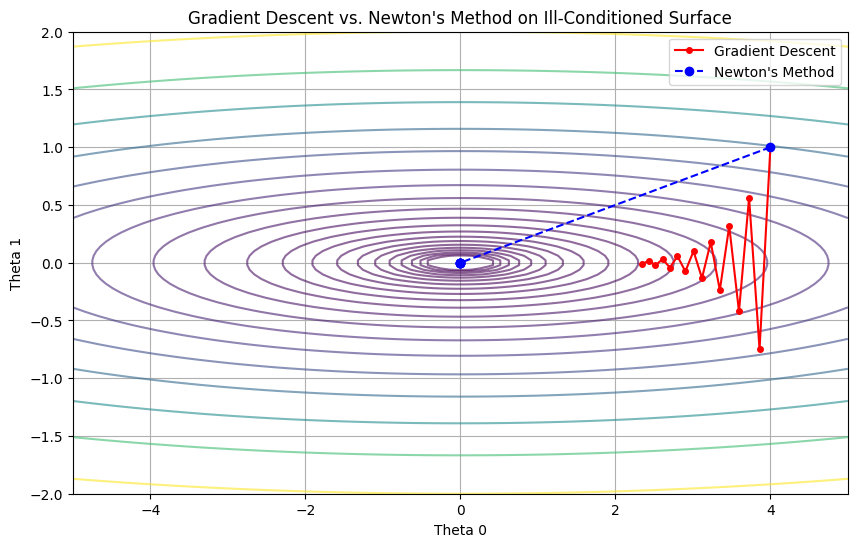

In [ ]:
import numpy as np
import matplotlib.pyplot as plt



H = np.array([[1.0, 0.0],
              [0.0, 50.0]])


def cost_func(v):
    return 0.5 * v.T @ H @ v


def gradient(v):
    return H @ v



def gradient_descent(start_theta, learning_rate, n_iters):
    path = [start_theta]
    theta = start_theta.copy()

    for _ in range(n_iters):
        grad = gradient(theta)
        theta = theta - learning_rate * grad
        path.append(theta)

    return np.array(path)

def newtons_method(start_theta, n_iters):
    path = [start_theta]
    theta = start_theta.copy()
    H_inv = np.linalg.inv(H)

    for _ in range(n_iters):
        grad = gradient(theta)
        
        theta = theta - H_inv @ grad
        path.append(theta)

    return np.array(path)




start_theta = np.array([4.0, 1.0])




gd_path = gradient_descent(start_theta, learning_rate=0.035, n_iters=15)


nm_path = newtons_method(start_theta, n_iters=5)


x_vals = np.linspace(-5, 5, 100)
y_vals = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x_vals, y_vals)
Z = np.zeros_like(X)


for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        vec = np.array([X[i, j], Y[i, j]])
        Z[i, j] = cost_func(vec)

plt.figure(figsize=(10, 6))


plt.contour(X, Y, Z, levels=np.logspace(-1, 2, 20), cmap='viridis', alpha=0.6)


plt.plot(gd_path[:, 0], gd_path[:, 1], 'o-', label='Gradient Descent', color='red', markersize=4)


plt.plot(nm_path[:, 0], nm_path[:, 1], 'o--', label="Newton's Method", color='blue', markersize=6)

plt.title("Gradient Descent vs. Newton's Method on Ill-Conditioned Surface")
plt.xlabel("Theta 0")
plt.ylabel("Theta 1")
plt.legend()
plt.grid(True)
plt.show()

Total Parameters: 160 (Objective: < 500)
Training SGD...
Training L-BFGS...
Training CG...


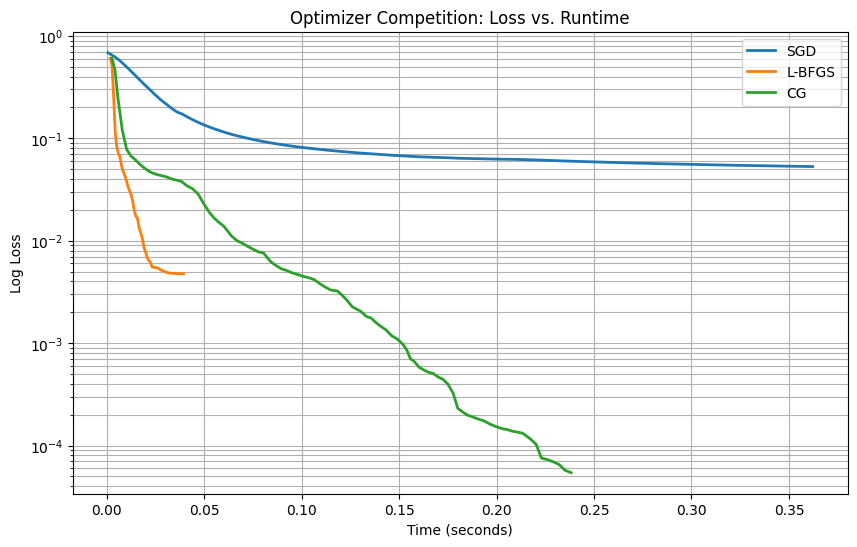

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize


data = load_breast_cancer()
X, y = data.data, data.target
y = y.reshape(-1, 1) 


scaler = StandardScaler()
X = scaler.fit_transform(X)


X = np.hstack([np.ones((X.shape[0], 1)), X])



input_size = X.shape[1]
hidden_size = 5
output_size = 1


np.random.seed(42)


n_params = input_size * hidden_size + hidden_size * output_size
initial_params = np.random.randn(n_params) * 0.1

print(f"Total Parameters: {n_params} (Objective: < 500)")

def sigmoid(z):
    return 1 / (1 + np.exp(-np.clip(z, -250, 250)))

def forward(params, X_data):
    
    W1_end = input_size * hidden_size
    W1 = params[:W1_end].reshape(input_size, hidden_size)
    W2 = params[W1_end:].reshape(hidden_size, output_size)

    
    z1 = X_data @ W1
    a1 = sigmoid(z1)
    z2 = a1 @ W2
    a2 = sigmoid(z2)
    return a2, a1, W1, W2

def loss_function(params, X_data, y_data):
    
    predictions, _, _, _ = forward(params, X_data)
    
    epsilon = 1e-15
    predictions = np.clip(predictions, epsilon, 1 - epsilon)
    loss = -np.mean(y_data * np.log(predictions) + (1 - y_data) * np.log(1 - predictions))
    return loss

def gradients(params, X_data, y_data):
    
    N = X_data.shape[0]
    predictions, a1, W1, W2 = forward(params, X_data)

    
    dz2 = predictions - y_data
    dW2 = (a1.T @ dz2) / N

    
    dz1 = (dz2 @ W2.T) * (a1 * (1 - a1)) 
    dW1 = (X_data.T @ dz1) / N

    return np.concatenate([dW1.ravel(), dW2.ravel()])




history = {}


print("Training SGD...")
start_time = time.time()
sgd_params = initial_params.copy()
lr = 0.1
sgd_history = []
epochs = 2000

for i in range(epochs):
    grad = gradients(sgd_params, X, y)
    sgd_params = sgd_params - lr * grad

    if i % 10 == 0: 
        current_loss = loss_function(sgd_params, X, y)
        sgd_history.append((time.time() - start_time, current_loss))

history['SGD'] = np.array(sgd_history)


def make_callback(name):
    start_t = time.time()
    path = []
    def callback(xk):
        
        
        l = loss_function(xk, X, y)
        path.append((time.time() - start_t, l))
    return path


print("Training L-BFGS...")
lbfgs_cb_data = make_callback('L-BFGS')
res_lbfgs = minimize(fun=loss_function,
                     x0=initial_params.copy(),
                     args=(X, y),
                     jac=gradients,
                     method='L-BFGS-B',
                     callback=lbfgs_cb_data.append) 



lbfgs_history = []
start_lbfgs = time.time()
def lbfgs_callback(xk):
    l = loss_function(xk, X, y)
    lbfgs_history.append((time.time() - start_lbfgs, l))

minimize(fun=loss_function, x0=initial_params.copy(), args=(X, y),
         jac=gradients, method='L-BFGS-B', callback=lbfgs_callback)
history['L-BFGS'] = np.array(lbfgs_history)


print("Training CG...")
cg_history = []
start_cg = time.time()
def cg_callback(xk):
    l = loss_function(xk, X, y)
    cg_history.append((time.time() - start_cg, l))

minimize(fun=loss_function, x0=initial_params.copy(), args=(X, y),
         jac=gradients, method='CG', callback=cg_callback)
history['CG'] = np.array(cg_history)



plt.figure(figsize=(10, 6))

for name, data_points in history.items():
    if len(data_points) > 0:
        plt.plot(data_points[:, 0], data_points[:, 1], label=name, linewidth=2)

plt.xlabel("Time (seconds)")
plt.ylabel("Log Loss")
plt.title("Optimizer Competition: Loss vs. Runtime")
plt.legend()
plt.yscale('log') 
plt.grid(True, which="both", ls="-")
plt.show()

100%|██████████| 26.4M/26.4M [00:01<00:00, 16.9MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 272kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.01MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.7MB/s]


Training on: cpu

--- Hessian Memory Analysis ---
Total Parameters (N): 99,710
Hessian Shape: (99710, 99710)
Total Elements: 9.94e+09
Memory Required (Float32): 37.04 GB
CONCLUSION: IMPOSSIBLE on most consumer hardware (RAM overflow).
------------------------------
Training with SGD_Momentum...
Training with Adam...


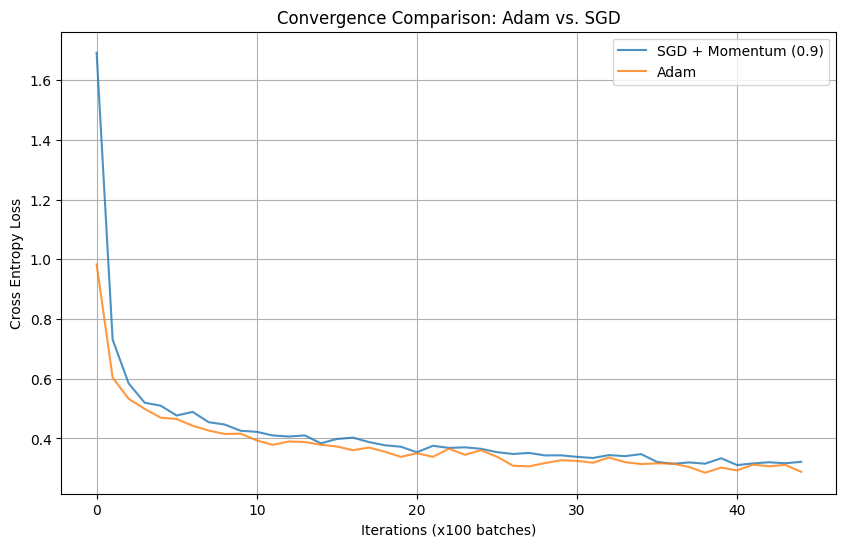

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np



transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])


trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Training on: {device}")


class DeepNet(nn.Module):
    def __init__(self):
        super(DeepNet, self).__init__()
        
        
        self.fc1 = nn.Linear(784, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 100)
        self.output = nn.Linear(100, 10) 
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 784) 
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.output(x)
        return x

model = DeepNet().to(device)


total_params = sum(p.numel() for p in model.parameters())
print(f"\n--- Hessian Memory Analysis ---")
print(f"Total Parameters (N): {total_params:,}")


hessian_elements = total_params ** 2

memory_bytes = hessian_elements * 4
memory_gb = memory_bytes / (1024 ** 3)

print(f"Hessian Shape: ({total_params}, {total_params})")
print(f"Total Elements: {hessian_elements:.2e}")
print(f"Memory Required (Float32): {memory_gb:.2f} GB")

if memory_gb > 32:
    print("CONCLUSION: IMPOSSIBLE on most consumer hardware (RAM overflow).")
else:
    print("CONCLUSION: Extremely expensive, likely slow to invert.")

print("-" * 30)



def train_model(optimizer_type, model_class, epochs=5):
    
    net = model_class().to(device)
    criterion = nn.CrossEntropyLoss()

    if optimizer_type == 'SGD_Momentum':
        optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
    elif optimizer_type == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=0.001)

    losses = []

    print(f"Training with {optimizer_type}...")
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            
            if i % 100 == 99:
                losses.append(running_loss / 100)
                running_loss = 0.0

    return losses


sgd_losses = train_model('SGD_Momentum', DeepNet)


adam_losses = train_model('Adam', DeepNet)


plt.figure(figsize=(10, 6))
plt.plot(sgd_losses, label='SGD + Momentum (0.9)', alpha=0.8)
plt.plot(adam_losses, label='Adam', alpha=0.8)
plt.title("Convergence Comparison: Adam vs. SGD")
plt.xlabel("Iterations (x100 batches)")
plt.ylabel("Cross Entropy Loss")
plt.legend()
plt.grid(True)
plt.show()

Covariance Matrix of X:
 [[0.08534424 0.08468374]
 [0.08468374 0.08646821]]


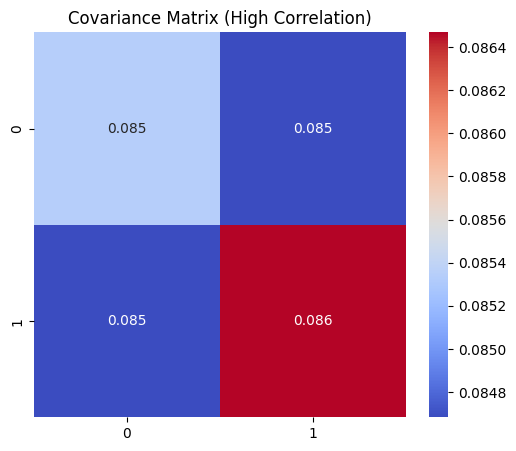


Check Orthogonality (Q.T @ Q):
[[ 1. -0.]
 [-0.  1.]]


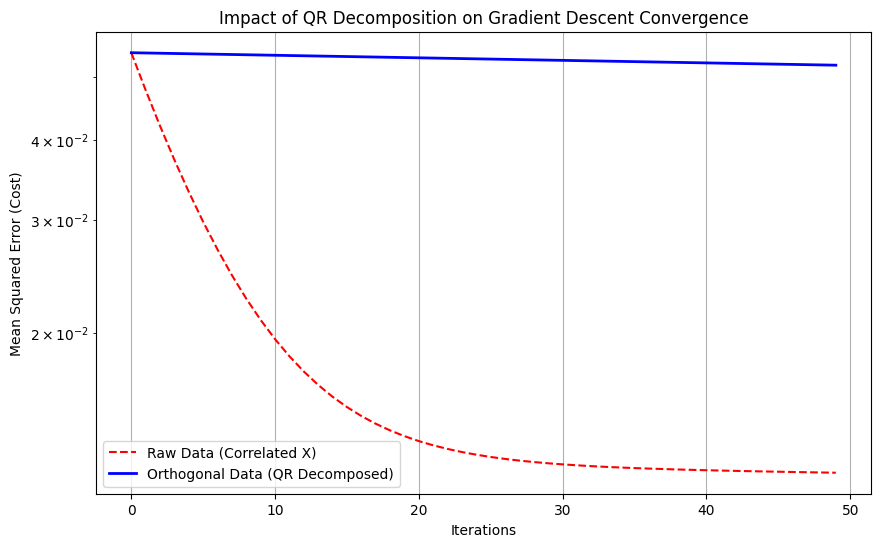

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


np.random.seed(42)
N = 1000

x1 = np.random.rand(N, 1)

x2 = x1 + np.random.normal(0, 0.05, (N, 1))


X_raw = np.hstack([x1, x2])

X_raw = X_raw - np.mean(X_raw, axis=0)


true_theta = np.array([[2], [-3]])
y = X_raw @ true_theta + np.random.normal(0, 0.1, (N, 1))


cov_matrix = np.cov(X_raw.T)
print("Covariance Matrix of X:\n", cov_matrix)

plt.figure(figsize=(6, 5))
sns.heatmap(cov_matrix, annot=True, cmap='coolwarm')
plt.title("Covariance Matrix (High Correlation)")
plt.show()




Q, R = np.linalg.qr(X_raw)


print("\nCheck Orthogonality (Q.T @ Q):")
print(np.round(Q.T @ Q, 2))



def train_linear_regression(features, target, learning_rate=0.1, iterations=100):
    m, n = features.shape
    theta = np.zeros((n, 1))
    cost_history = []

    for _ in range(iterations):
        
        y_pred = features @ theta

        
        error = y_pred - target

        
        gradients = (1/m) * (features.T @ error)

        
        theta = theta - learning_rate * gradients

        
        cost = (1/(2*m)) * np.sum(error**2)
        cost_history.append(cost)

    return cost_history



loss_X = train_linear_regression(X_raw, y, learning_rate=0.5, iterations=50)



loss_Q = train_linear_regression(Q, y, learning_rate=0.5, iterations=50)


plt.figure(figsize=(10, 6))
plt.plot(loss_X, label='Raw Data (Correlated X)', color='red', linestyle='--')
plt.plot(loss_Q, label='Orthogonal Data (QR Decomposed)', color='blue', linewidth=2)
plt.xlabel('Iterations')
plt.ylabel('Mean Squared Error (Cost)')
plt.title('Impact of QR Decomposition on Gradient Descent Convergence')
plt.legend()
plt.grid(True)
plt.yscale('log') 
plt.show()

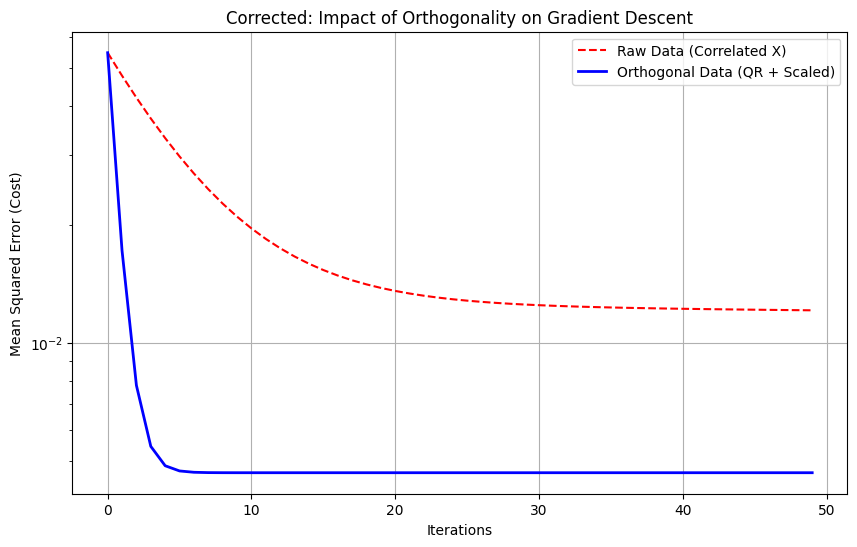

In [ ]:
import numpy as np
import matplotlib.pyplot as plt



np.random.seed(42)
N = 1000


x1 = np.random.rand(N, 1)

x2 = x1 + np.random.normal(0, 0.05, (N, 1))


X_raw = np.hstack([x1, x2])

X_raw = X_raw - np.mean(X_raw, axis=0)


true_theta = np.array([[2], [-3]])
y = X_raw @ true_theta + np.random.normal(0, 0.1, (N, 1))


Q, R = np.linalg.qr(X_raw)




Q_scaled = Q * np.sqrt(N)


def train_linear_regression(features, target, learning_rate, iterations):
    m, n = features.shape
    theta = np.zeros((n, 1))
    cost_history = []

    for _ in range(iterations):
        
        y_pred = features @ theta

        
        error = y_pred - target

        
        gradients = (1/m) * (features.T @ error)

        
        theta = theta - learning_rate * gradients

        
        cost = (1/(2*m)) * np.sum(error**2)
        cost_history.append(cost)

    return cost_history



loss_X = train_linear_regression(X_raw, y, learning_rate=0.5, iterations=50)


loss_Q = train_linear_regression(Q_scaled, y, learning_rate=0.5, iterations=50)


plt.figure(figsize=(10, 6))


plt.plot(loss_X, label='Raw Data (Correlated X)', color='red', linestyle='--')


plt.plot(loss_Q, label='Orthogonal Data (QR + Scaled)', color='blue', linewidth=2)

plt.xlabel('Iterations')
plt.ylabel('Mean Squared Error (Cost)')
plt.title('Corrected: Impact of Orthogonality on Gradient Descent')
plt.legend()
plt.grid(True)
plt.yscale('log') 
plt.show()